<a href="https://colab.research.google.com/github/MakeevIlia/Computer-Vision/blob/main/Cleaned_Dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
from tqdm import tqdm
import os
import zipfile

val_percent = 0.2


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

with zipfile.ZipFile('/content/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/data')

data_root = '/content/data/plates'

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % int(1/ val_percent) != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5377.64it/s]


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import torchvision
from torchvision import transforms, models

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transforms_org = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_transforms_mod = transforms.Compose([
    transforms.RandomResizedCrop(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.8),
    transforms.RandomVerticalFlip(p = 0.8),
    transforms.RandomInvert(p=0.5),
    transforms.ColorJitter(0.1, 2, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

orig = 5
modif = 20
batch_size = 16


train_ds = []
for i in range(modif):
  train_dataset_mod = torchvision.datasets.ImageFolder(train_dir, train_transforms_mod)
  train_ds.append(train_dataset_mod)

for i in range(orig):
  train_dataset_org = torchvision.datasets.ImageFolder(train_dir, train_transforms_org)
  train_ds.append(train_dataset_org)

train_dataset = torch.utils.data.ConcatDataset(train_ds)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    test_accuracy_history = []
    test_loss_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            if phase == 'val':
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

        if phase == 'val':
          test_loss_history.append(epoch_loss)
          test_accuracy_history.append(epoch_acc.cpu())

    return test_loss_history, test_accuracy_history

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 10),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(10),

    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(5),

    torch.nn.Linear(5, 2),
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-1)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
torch.manual_seed(0);
loss_history, acc_history = train_model(model, loss, optimizer, scheduler, num_epochs=70);

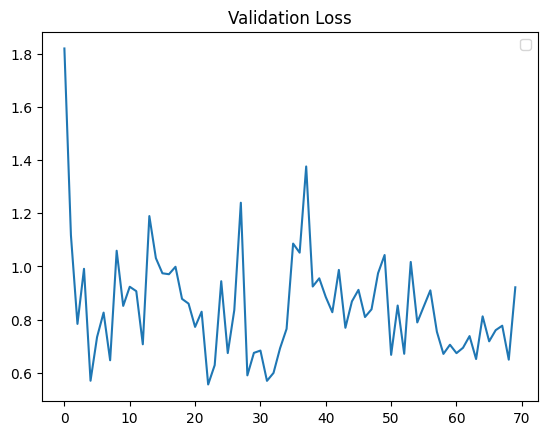

In [ ]:
plt.plot(loss_history)
plt.legend()
plt.title('Validation Loss');

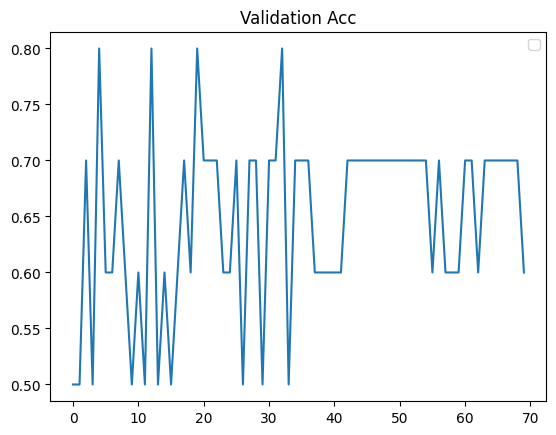

In [ ]:
plt.plot(acc_history)
plt.legend()
plt.title('Validation Acc');

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths('/content/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.to_csv('/content/submission.csv')